# Stroke Prediction: A Binary Classification Problem

1. [Problem Setting](#0)
2. [Setup: Importing Libraries and Data](#1)
3. [Exploratory Data Analysis (EDA)](#2)
4. [Data Preprocessing](#3)
5. [Feature Engineering & Selection for Logistic Regression](#4)
6. [Model Selection & Evaluation](#5)
7. [Conclusion](#7)


## Problem Setting <a id="0"></a>


In this notebook, I will work on a supervised binary classification problem to predict whether a subject is a stroke patient or not. The binary dependent target variable is `stroke` (1 if the patient had a stroke, 0 otherwise). The dataset contains 11 features including the target variable, which are as follows:

-   `id` (discrete): unique identifier
-   `gender` (discrete, binary): gender of the subject (`Male`, `Female`)
-   `age` (continuous): age of the subject in years
-   `hypertension` (discrete, binary): 0 if the subject doesn't have hypertension, 1 if the subject has hypertension
-   `heart_disease` (discrete, binary): 0 if the subject doesn't have any heart diseases, 1 if the subject has a heart disease
-   `work_type` (discrete): the type of occupation of the subject (`children`, `Govt_job`, `Never_worked`, `Private`, `Self-employed`)
-   `Residence_type` (discrete, binary): area type of residence of the subject (`Rural`, `Urban`)
-   `avg_glucose_level` (continuous): average glucose level in blood of the subject in mg/dL
-   `bmi` (continuous): body mass index of the subject in kg/m^2
-   `smoking_status` (discrete): the smoking status of the subject (`formerly smoked`, `never smoked`, `smokes`, `Unknown`)
-   target: `stroke` (discrete, binary): 1 if the subject had a stroke or 0 otherwise

The data is fictional. The data set used for training contains 5000 observations, whereas the test data consists of 1000 samples. The training set is imbalanced, with around 90 % of the samples containing the target value 0.

I will use the following metrics for evaluation:

-   Accuracy
-   Precision
-   Recall
-   F1 Score
-   ROC AUC Score
-   Confusion Matrix

Given that the data is imbalanced, accuracy can be misleading, and I will use the ROC AUC score as the main evaluation metric.

I will train two models, one linear model (Logistic Regression) and one non-linear model ((Deep) Neural Network), and compare their performance. Both of them will have the weighted cross-entropy as loss function, to account for the class imbalance.


## Setup: Importing Libraries and Data <a id="1"></a>

First: import all necessary dependencies.


In [1]:
%load_ext autoreload
%autoreload 2

import random
import sys
from pathlib import Path

base_path = Path().resolve().parent
sys.path.append(str(base_path))


import numpy as np
from loguru import logger
import pandas as pd

from src.data_preparation import load_data, min_max_normalize, replace_na, transform_non_numericals, create_polynomials, transform_polynomials, create_pca, transform_pca
from sklearn.model_selection import train_test_split
from sklearn.utils import check_random_state
from src.training import BinaryLogisticRegression, BinaryNeuralNetwork, NaiveBaseline, evaluate, feature_selection, nested_cross_validation
from src.data_understanding import plot_distributions, print_na, print_non_numericals, plot_relative_distributions

Setting seed values for reproducibility:


In [12]:
# set seeds for sklearn, numpy, pandas
seed = 42
random.seed(seed)
np.random.seed(seed)
random_state = check_random_state(seed)

## Exploratory Data Analysis (EDA) <a id="2"></a>


### Data Exploration

By creating a first graphical representation of the data at hand, I will get a better understanding of the underlying distributions.


In [13]:
# load data
path_data_train = "data/train.csv"
path_data_test = "data/test.csv"

data_train_raw = load_data(base_path / path_data_train)
data_test_raw = load_data(base_path / path_data_test)

data_train_raw.drop(columns=["id"], inplace=True)
test_ids = data_test_raw["id"]
data_test_raw.drop(columns=["id"], inplace=True)

# print the number of `stroke` == 1 values
print(data_train_raw["stroke"].value_counts())

2024-08-05 16:32:19.598 | SUCCESS  | src.data_preparation.data_loading:load_data:12 - Successfully created Pandas Dataframe from raw data.

2024-08-05 16:32:19.600 | SUCCESS  | src.data_preparation.data_loading:load_data:12 - Successfully created Pandas Dataframe from raw data.



stroke
0    4502
1     498
Name: count, dtype: int64


I will plot the distributions of the raw data to get an initial understanding of what I am working with.


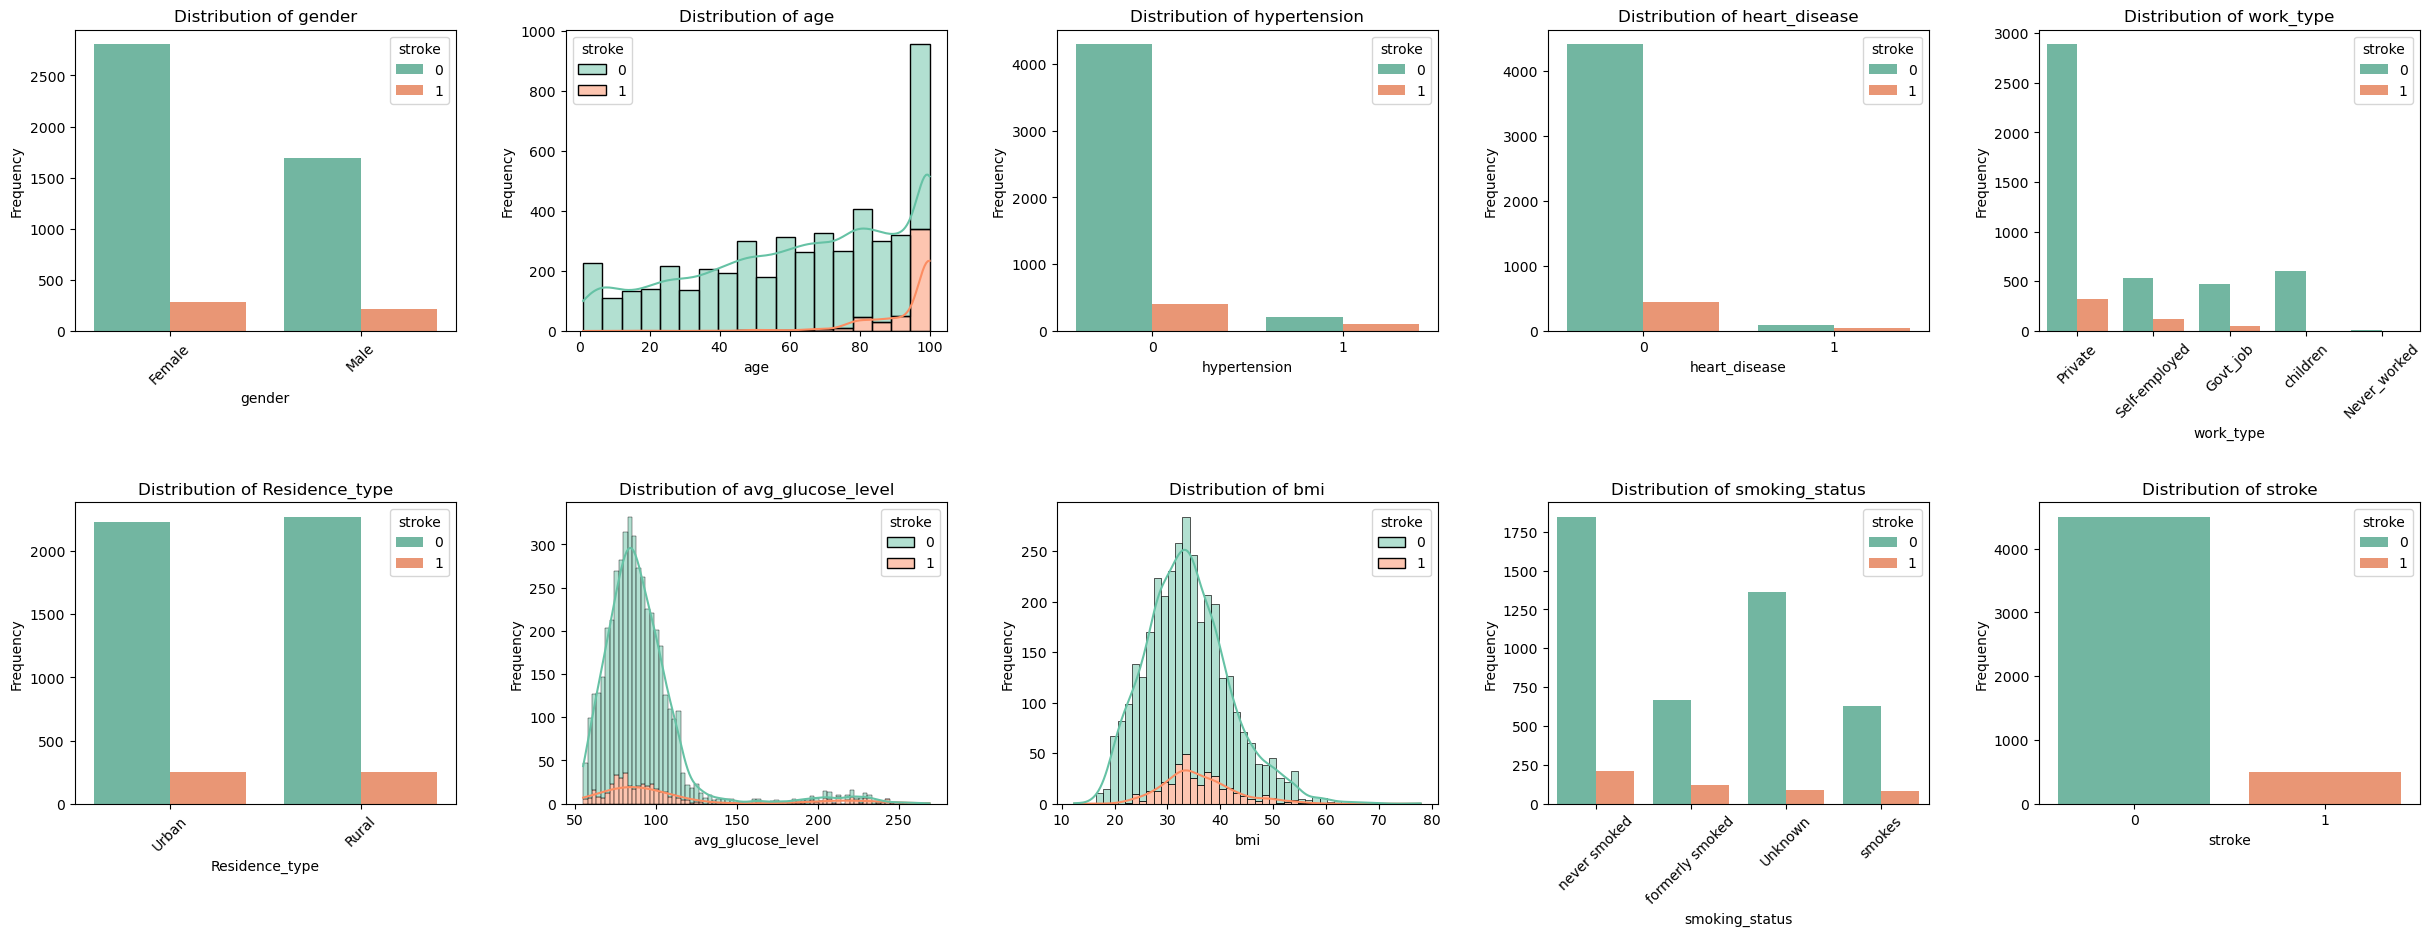

In [14]:
plot_distributions(data_train_raw)

Some important first insights:

-   The dataset is highly imbalanced: There are many more instances of people who did not have a stroke than those who did. This will require special attention during model training and evaluation.
-   There are a mix of numerical and categorical features. This will need to be taken care of during preprocessing.
-   Regarding the numerical features:
    -   The features have different scales. I will normalize them using min-max normalization.
-   Regarding the categorical features:
    -   Some categorical features are binary, while others have more than two values.
    -   The categorical features with more than two values are nominal, i.e., there is no inherent order in the categories. I will one-hot encode them.
        -   Note: The `smoking_status` feature could be interpreted as ordinal in some sense ("time since last cigarette"), however, the influence of this underlying order on the target variable is not clear. I will treat it as a nominal feature.


To make sure that the training and test data come from the same underlying distribution, plot the test data as well:


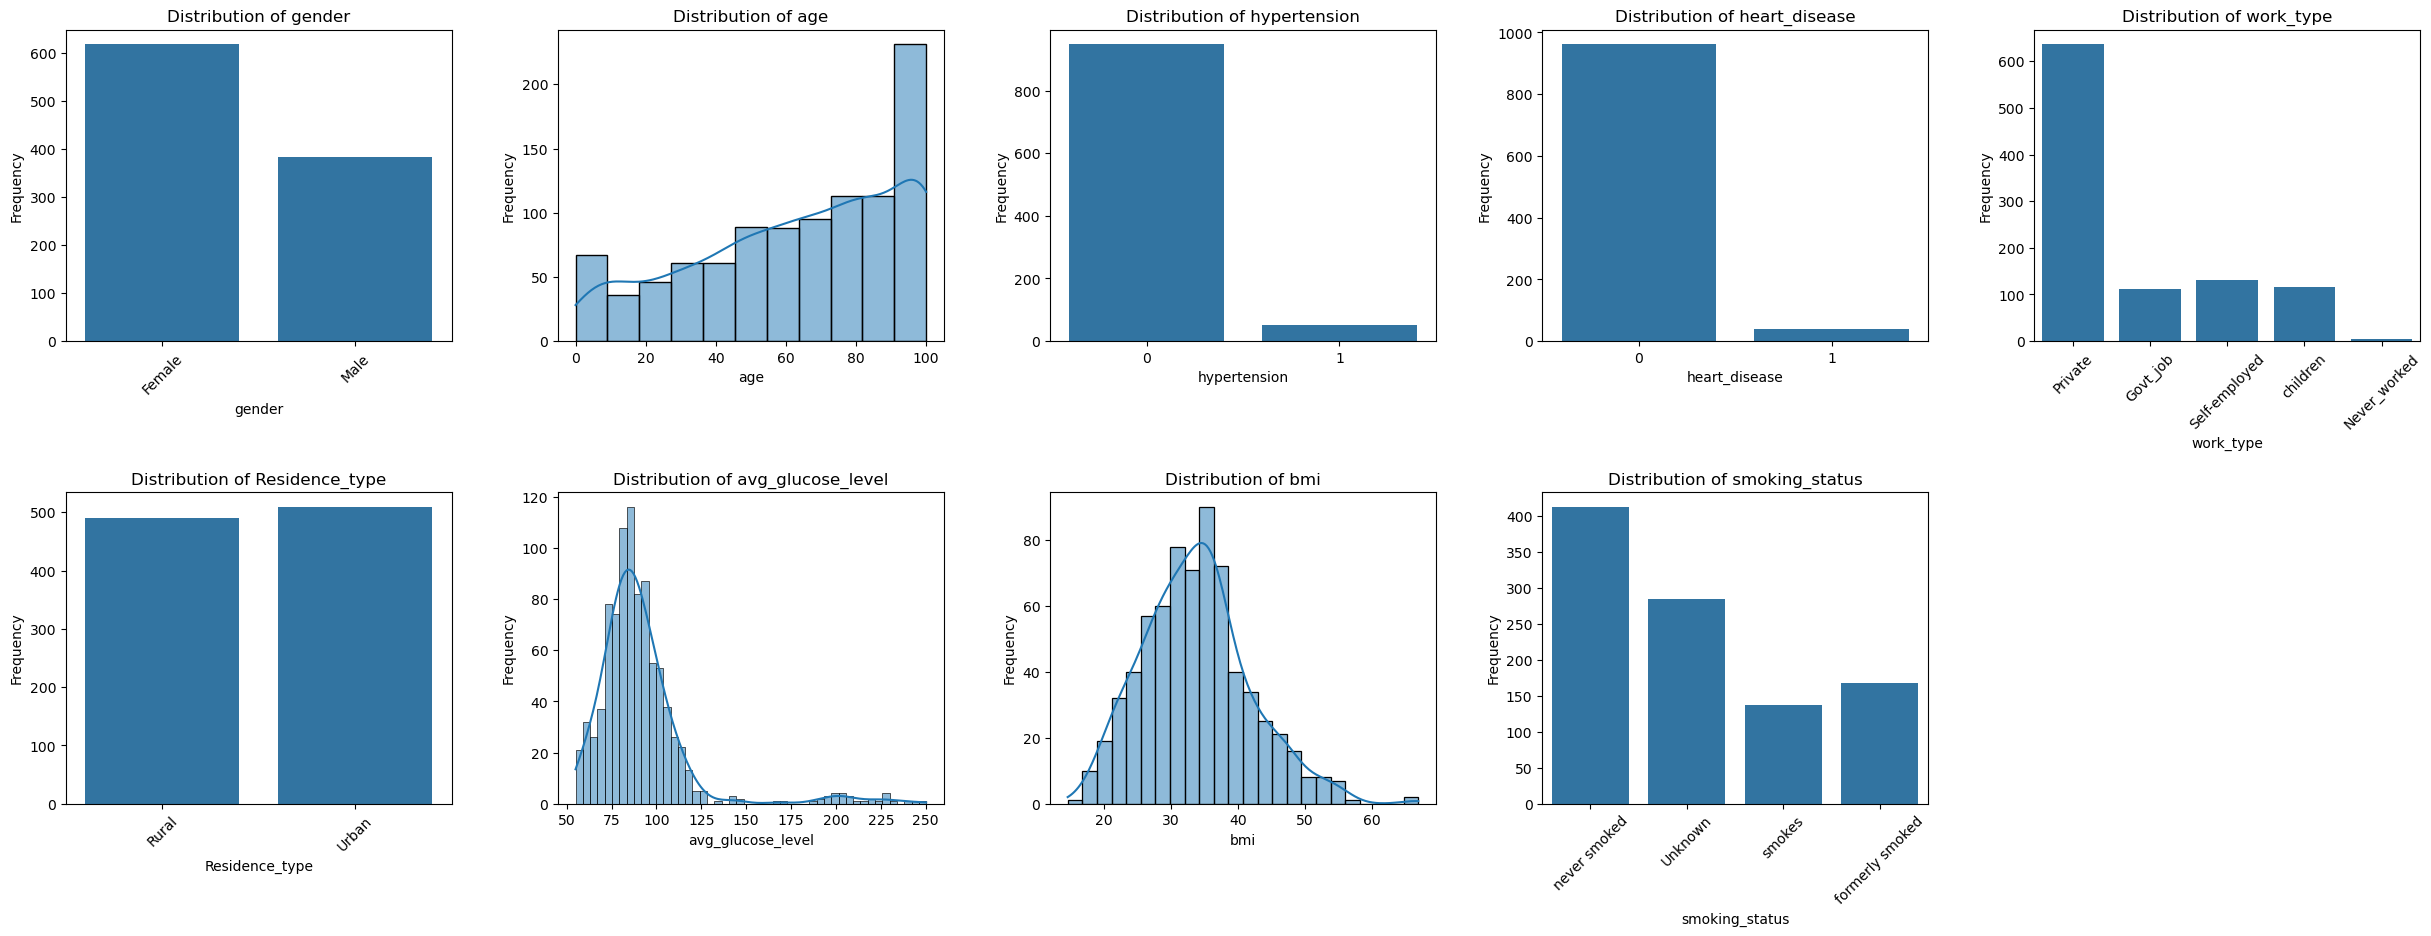

In [15]:
plot_distributions(data_test_raw)

Looks fine: No significant covariate shift is apparent. The distribution of some features, such as `smoking_status` and `work_type`, may differ slightly between the training and test data, but it seems more likely that the relatively small sample size creates this illusion.

Next, I'll have a look at the relative distributions of the target variable `stroke` over the features of the training data.


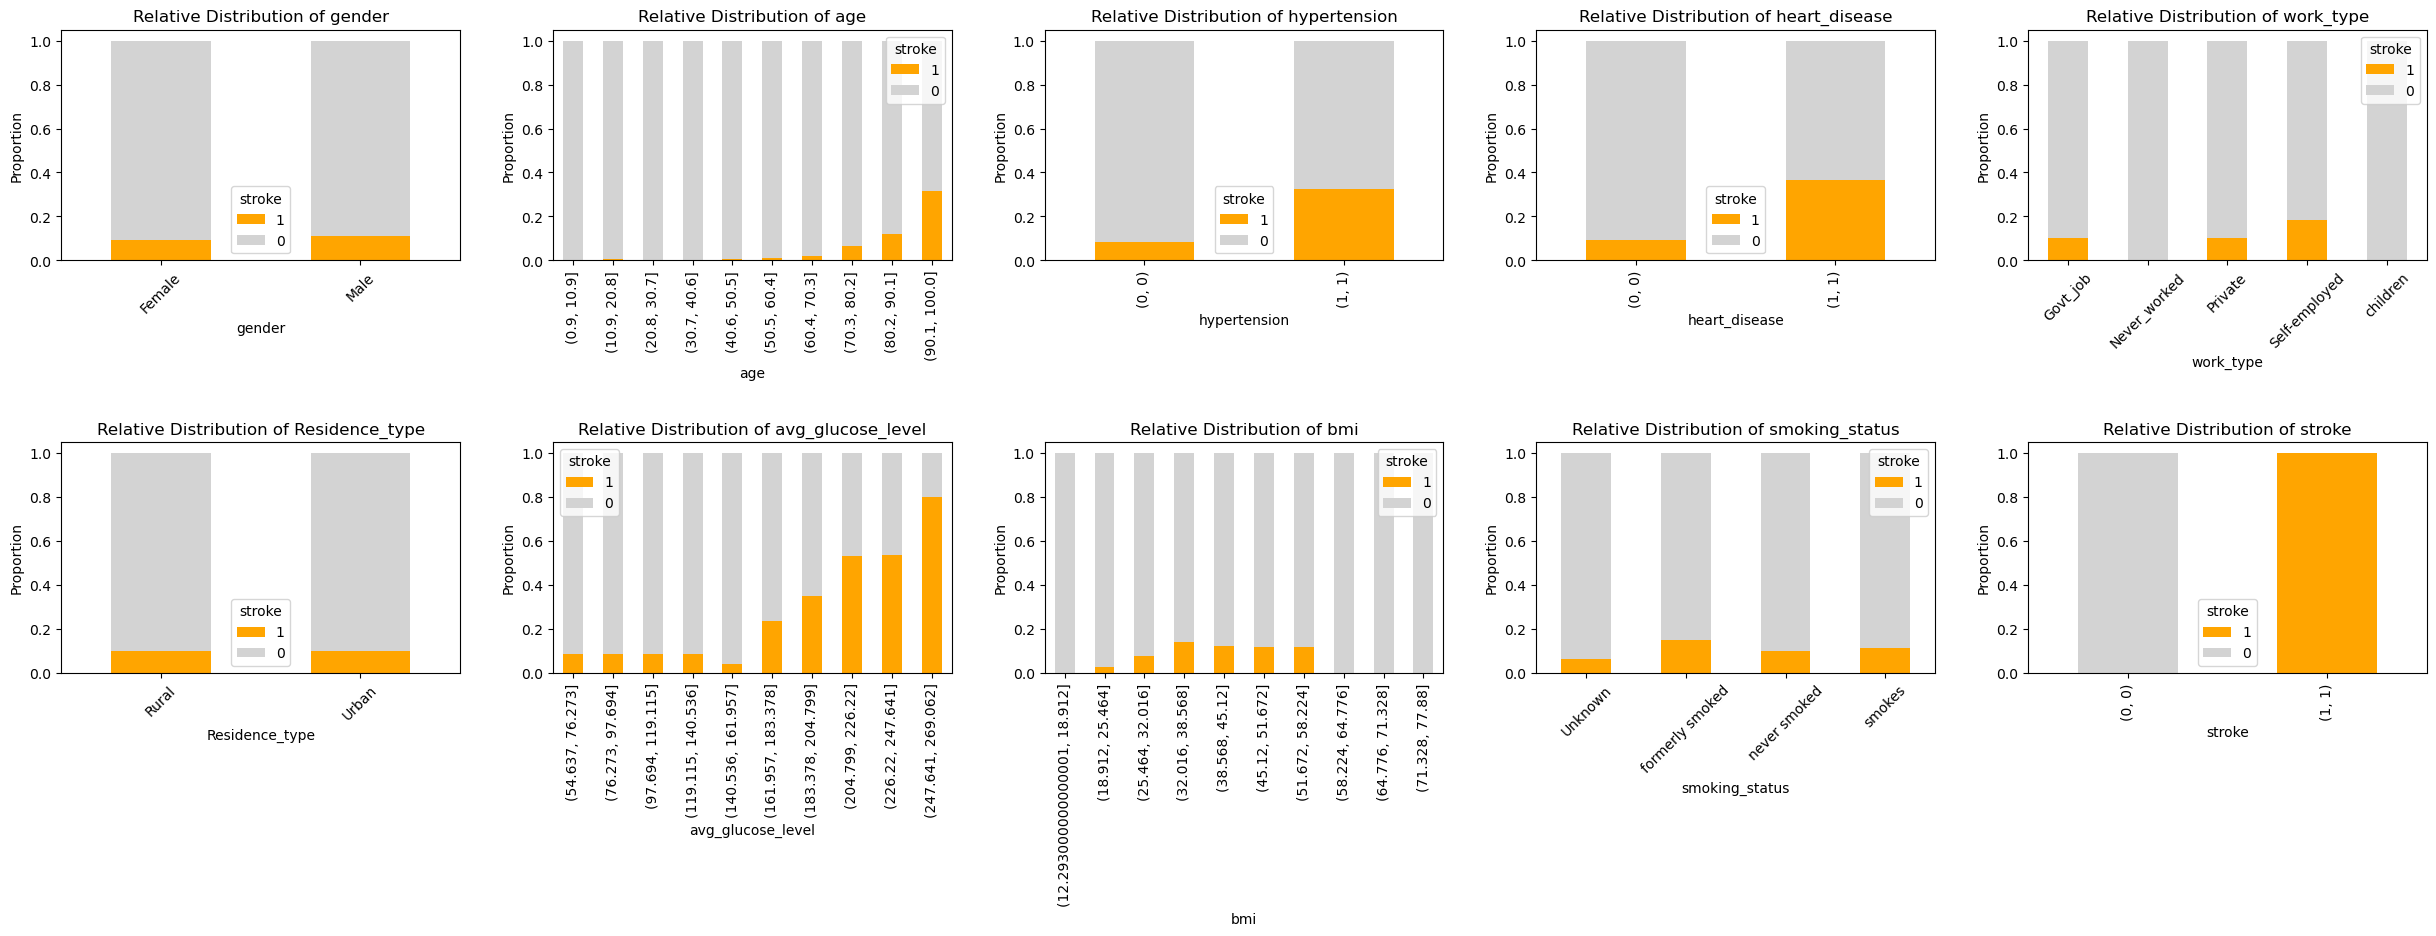

In [16]:
plot_relative_distributions(data_train_raw)

Some more important insights:

-   Regarding the continuous features:
    -   The relation of `age` and `bmi` with the likelihood of `stroke` seems to be positive and may be non-linear.
    -   `avg_glucose_level` might have a positive linear relation with target variable, potentially starting at a certain threshold.
-   Regarding the categorical features:
    -   `hypertension` and `heart_disease` seem to have a significant positive relation with the target variable.
    -   `work_type`: People who are self-employed seem to have a slightly higher chance of having a stroke. People who never worked or care for their children have a lower chance. Government workers and private workers seem to have a similar distribution.
    -   Both `gender` and `Residence_type` seem to have no significant influence on the target variable in isolation. However, there might be interaction effects with other features.

These are just first impressions. I did not test significance. Furthermore, I only yet looked at the features and their potential relationships with the target variable in isolation. Interaction effects may yet occur, and taking them into account by building polynomial features for the models may improve model performance.


In [17]:
print_na(data_train_raw)
print_non_numericals(data_train_raw)

2024-08-05 16:32:21.958 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column gender: 0 / 5000
2024-08-05 16:32:21.959 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column age: 0 / 5000
2024-08-05 16:32:21.959 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column hypertension: 0 / 5000
2024-08-05 16:32:21.960 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column heart_disease: 0 / 5000
2024-08-05 16:32:21.961 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column work_type: 0 / 5000
2024-08-05 16:32:21.961 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column Residence_type: 0 / 5000
2024-08-05 16:32:21.962 | INFO     | src.data_understanding.data_exploration:print_na:133 - Number of NaN values in column avg_glucose_leve

There are 2756 / 5000 data points with at least one missing value. This will need to be addressed in the preprocessing step. Since there are so many data points with missing values, I will not simply drop them.

-   For the continuous features `avg_glucose_level` and `bmi`, I will impute the missing values with the median of the respective feature.
-   For the categorical feature `smoking_status`, the missing values currently make up a separate category called "Unknown". I will treat this category as a separate category in the one-hot encoding step.


## Data Preprocessing <a id="3"></a>


In this section, I will preprocess the data to prepare it for model training. Specifically, I will:

-   Transform non-numerical features into numerical ones. This is done using one-hot encoding.
-   Replace missing values in the continuous features with the median of that respective feature, in order to retain as much information as possible.
-   Normalize the numerical features using min-max normalization. I will make all features have the same scale, which avoids gradient problems during neural network training.


In [18]:
data_train_preprocessed = transform_non_numericals(data_train_raw)
data_train_preprocessed = replace_na(data_train_preprocessed, replace_with="median")
data_train_preprocessed = min_max_normalize(data_train_preprocessed)

data_test_preprocessed = transform_non_numericals(data_test_raw)
data_test_preprocessed = replace_na(data_test_preprocessed, replace_with="median")
data_test_preprocessed = min_max_normalize(data_test_preprocessed)

X_original = data_train_preprocessed.drop(columns=["stroke"]).copy().to_numpy()
y_original = data_train_preprocessed["stroke"].copy().to_numpy()
X_test_original = data_test_preprocessed.copy().to_numpy()

2024-08-05 16:32:21.985 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:30 - Transformed gender into binary encoding
2024-08-05 16:32:21.987 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:34 - Transformed work_type into one-hot encoding
2024-08-05 16:32:21.988 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:30 - Transformed Residence_type into binary encoding
2024-08-05 16:32:21.989 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:34 - Transformed smoking_status into one-hot encoding
2024-08-05 16:32:21.991 | INFO     | src.data_preparation.data_preprocessing:replace_na:17 - Replaced NaN values with median
2024-08-05 16:32:21.993 | INFO     | src.data_preparation.data_preprocessing:min_max_normalize:50 - Normalized data using min-max normalization
2024-08-05 16:32:21.994 | INFO     | src.data_preparation.data_preprocessing:transform_non_numericals:30 - Transformed gen

## Feature Engineering & Selection for Logistic Regression <a id="4"></a>


Next, I will create new features for the Logistic Regression model by combining existing ones, using polynomials and Principal Component Analysis (PCA). This way, non-linear relationships between features and target can be mapped to linear relationships. This may allow the Logistic Regression model to find a seperation it would otherwise not be able to discover, given its linear nature. The Neural Network will be trained with the original features, as it is able to learn non-linear relationships between features and target during training if they exist. Given the modest complexity of the Logistic Regression model, I will use primal decision functions, creating explicit mappings &\Phi{X}$ as input. Apart from creating polynomial features, I will also use PCA to compute the principal components of the data, incorporating both the original features and the polynomial ones.

After creating the new features (polynomials and principal components), I will select the most relevant ones, reducing the dimensionality of the feature space to avoid overfitting and reduce training times. This will be done using backward selection, leveraging a Logistic Regression model by scikit-learn.


### Feature Engineering: Polynomial Features


I am going to create polynomial features of degree 2, so for each pair of features $\set{x_1, x_2}$ there will be a new set $\set{x_1 x_2, x_1^2, x_2^2}$ that will be added to the feature space.


In [19]:
d_poly = 2

# feature cols without target
feature_columns = data_train_preprocessed.columns.drop("stroke")

polynomials_train, feature_names = create_polynomials(
    data_train_preprocessed, feature_columns, degree=d_poly
)
print(f"Features in polynomial_train: {polynomials_train.columns}")
polynomials_test = transform_polynomials(data_test_preprocessed, feature_names)

logger.info(f"Data preprocessed train shape: {data_train_preprocessed.shape}")
logger.info(f"Data preprocessed test shape: {data_test_preprocessed.shape}")
logger.info(f"Polynomials train shape: {polynomials_train.shape}")
logger.info(f"Polynomials test shape: {polynomials_test.shape}")

2024-08-05 16:32:22.134 | INFO     | __main__:<module>:12 - Data preprocessed train shape: (5000, 17)
2024-08-05 16:32:22.134 | INFO     | __main__:<module>:13 - Data preprocessed test shape: (1000, 16)
2024-08-05 16:32:22.135 | INFO     | __main__:<module>:14 - Polynomials train shape: (5000, 153)
2024-08-05 16:32:22.135 | INFO     | __main__:<module>:15 - Polynomials test shape: (1000, 152)


Features in polynomial_train: Index(['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type',
       'avg_glucose_level', 'bmi', 'stroke', 'work_type_Govt_job',
       'work_type_Never_worked',
       ...
       'smoking_status_Unknown^smoking_status_Unknown',
       'smoking_status_Unknown^smoking_status_formerly smoked',
       'smoking_status_Unknown^smoking_status_never smoked',
       'smoking_status_Unknown^smoking_status_smokes',
       'smoking_status_formerly smoked^smoking_status_formerly smoked',
       'smoking_status_formerly smoked^smoking_status_never smoked',
       'smoking_status_formerly smoked^smoking_status_smokes',
       'smoking_status_never smoked^smoking_status_never smoked',
       'smoking_status_never smoked^smoking_status_smokes',
       'smoking_status_smokes^smoking_status_smokes'],
      dtype='object', length=153)


There are a total of 152 features now. Next, I will add a total of eight principal components to the feature space.


In [21]:
n_pcs = 8

pcs_train, pca = create_pca(polynomials_train, feature_columns, n_components=n_pcs)
pcs_test = transform_pca(polynomials_test, pca, feature_columns)

logger.info(f"Principal components train shape: {pcs_train.shape}")
logger.info(f"Principal components test shape: {pcs_test.shape}")

2024-08-05 16:32:28.496 | INFO     | __main__:<module>:6 - Principal components train shape: (5000, 8)
2024-08-05 16:32:28.497 | INFO     | __main__:<module>:7 - Principal components test shape: (1000, 8)


Bringing all the features together:


In [22]:
data_train_tmp = pd.concat([polynomials_train, pcs_train], axis=1)
data_test_tmp = pd.concat([polynomials_test, pcs_test], axis=1)

feature_names_tmp = data_train_tmp.drop(columns=["stroke"]).columns.to_list()

X_tmp = data_train_tmp.drop(columns=["stroke"]).copy().to_numpy()
y_tmp = data_train_tmp["stroke"].copy().to_numpy()
X_test_tmp = data_test_tmp.copy().to_numpy()

logger.info(f"First ten features in data_train_tmp: {feature_names_tmp[0:10]}")
logger.info(f"Last ten features in data_train_tmp: {feature_names_tmp[-10:]}")
logger.info(f"First ten features in data_test_tmp: {data_test_tmp.columns[0:10]}")
logger.info(f"Last ten features in data_test_tmp: {data_test_tmp.columns[-10:]}")

2024-08-05 16:32:30.090 | INFO     | __main__:<module>:10 - First ten features in data_train_tmp: ['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type', 'avg_glucose_level', 'bmi', 'work_type_Govt_job', 'work_type_Never_worked', 'work_type_Private']
2024-08-05 16:32:30.090 | INFO     | __main__:<module>:11 - Last ten features in data_train_tmp: ['smoking_status_never smoked^smoking_status_smokes', 'smoking_status_smokes^smoking_status_smokes', 'PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8']
2024-08-05 16:32:30.091 | INFO     | __main__:<module>:12 - First ten features in data_test_tmp: Index(['gender', 'age', 'hypertension', 'heart_disease', 'Residence_type',
       'avg_glucose_level', 'bmi', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private'],
      dtype='object')
2024-08-05 16:32:30.092 | INFO     | __main__:<module>:13 - Last ten features in data_test_tmp: Index(['smoking_status_never smoked^smoking_status_smokes',
       'smoking_stat

### Feature Selection


To select the most important features, I will leverage backward selection, training the scikit-learn Logistic Regression model with L1 regularization, effectively forcing competition between features, leading to the model setting many features' weights to 0. I will drop the five features with the weakest weights per iteration. The features that the model with the lowest empirical risk estimate used will be the final ones used for training the models. An error margin will be used to tendencially remove more features if the decrease of empirical risk is below the threshold.


i = 0 / 159 – Empirical Risk Estimate: 0.4967626068218366, Previous Estimate: inf – new lowest risk estimate
i = 1 / 159 – Empirical Risk Estimate: 0.49676305896665984, Previous Estimate: 0.4967626068218366
i = 2 / 159 – Empirical Risk Estimate: 0.4967645929649601, Previous Estimate: 0.49676305896665984
i = 3 / 159 – Empirical Risk Estimate: 0.496763289302751, Previous Estimate: 0.4967645929649601
i = 4 / 159 – Empirical Risk Estimate: 0.49676341322488565, Previous Estimate: 0.496763289302751
i = 5 / 159 – Empirical Risk Estimate: 0.4967640950958682, Previous Estimate: 0.49676341322488565
i = 6 / 159 – Empirical Risk Estimate: 0.4967625843167142, Previous Estimate: 0.4967640950958682 – new lowest risk estimate
i = 7 / 159 – Empirical Risk Estimate: 0.49676423246553864, Previous Estimate: 0.4967625843167142
i = 8 / 159 – Empirical Risk Estimate: 0.4967640865848359, Previous Estimate: 0.49676423246553864
i = 9 / 159 – Empirical Risk Estimate: 0.4967641201216384, Previous Estimate: 0.4967

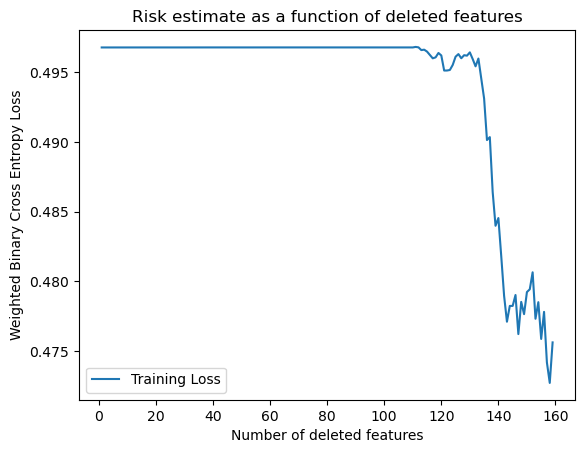

Features to delete (157, thereof unique 157): [0, 1, 2, 3, 4, 5, 6, 7, 8, 84, 63, 64, 62, 143, 61, 74, 134, 68, 132, 147, 58, 141, 57, 71, 131, 146, 135, 133, 54, 110, 53, 109, 108, 107, 66, 51, 50, 111, 105, 45, 46, 44, 47, 139, 103, 102, 101, 41, 42, 138, 99, 98, 65, 97, 121, 140, 125, 149, 123, 122, 56, 142, 144, 137, 78, 39, 126, 148, 34, 145, 33, 114, 120, 119, 76, 127, 75, 89, 128, 118, 117, 116, 94, 91, 69, 150, 92, 95, 154, 24, 157, 23, 151, 153, 96, 87, 36, 115, 10, 158, 11, 28, 12, 90, 13, 14, 15, 16, 37, 83, 129, 30, 136, 17, 49, 77, 104, 26, 85, 43, 9, 27, 152, 159, 38, 81, 73, 29, 31, 130, 113, 60, 18, 72, 67, 48, 19, 70, 82, 25, 20, 55, 35, 88, 80, 79, 112, 52, 155, 156, 93, 22, 21, 59, 106, 40, 124]


In [23]:
features_to_delete, risk_estimates = feature_selection(
    X_tmp,
    y_tmp,
    plot=True,
)
print(
    f"Features to delete ({len(features_to_delete)}, thereof unique {len(set(features_to_delete))}): {features_to_delete}"
)

Creating new references `X_train_selected`, `X_val_selected` and `X_test_selected`:


In [27]:
# drop the features
logger.info(f"Shape of X_tmp before feature selection: {X_tmp.shape}")
logger.info(f"Shape of X_test_selected before feature selection: {X_test_tmp.shape}")

X_selected = np.delete(X_tmp, features_to_delete, axis=1)
y_selected = y_tmp
X_test_selected = np.delete(X_test_tmp, features_to_delete, axis=1)

X_train_selected, X_val_selected, y_train_selected, y_val_selected = train_test_split(
    X_selected, y_selected, test_size=0.2
)

logger.info(
    f"Shape of X_train_selected after feature selection: {X_train_selected.shape}"
)
logger.info(f"Shape of X_val_selected after feature selection: {X_val_selected.shape}")
logger.info(
    f"Shape of X_test_selected after feature selection: {X_test_selected.shape}"
)

2024-08-04 17:45:48.519 | INFO     | __main__:<module>:2 - Shape of X_tmp before feature selection: (5000, 160)
2024-08-04 17:45:48.520 | INFO     | __main__:<module>:3 - Shape of X_test_selected before feature selection: (1000, 160)
2024-08-04 17:45:48.521 | INFO     | __main__:<module>:13 - Shape of X_train_selected after feature selection: (4000, 3)
2024-08-04 17:45:48.522 | INFO     | __main__:<module>:16 - Shape of X_val_selected after feature selection: (1000, 3)
2024-08-04 17:45:48.522 | INFO     | __main__:<module>:17 - Shape of X_test_selected after feature selection: (1000, 3)


## Model Selection & Evaluation <a id="5"></a>


I will first present the Naive Baseline model. Each prediction here is as likely to be positive as the probability to encounter a positive class in the training data given one draw. I will use this as a baseline to compare the other models against.

After that, for each model I will use an implementation of nested cross-validation to optimize the hyperparameters for the model and evaluate its performance. The nested cross-validation scheme consists of an outer loop with five folds and an inner loop with a five-fold cross-validation that does a grid-search on all combinations of hyperparameters given to the function, with the weighted binary cross-entropy loss as risk metric. The evaluation metrics after hyperparameter tuning will be the ROC AUC score, the F1 score, the confusion matrix, and the precision and recall scores. The accuracy will be reported as well, but it will not be used for model selection, given the class imbalance. The best model will be selected based on the ROC AUC score and will be used to predict the target variable on the test data.

I will train a linear logistic regression model and a non-linear neural network model. I decided for these two models because they allow to compare a linear approach with a non-linear one while maintaining similar structures: Neural Networks can be regarded as an extension of logistic regression models, with additional non-linear transformations of the input through activation functions and thus, more complex decision boundaries. This comparison is especially interesting given the polynomial features that were previously created. The logistic regression model will use these features directly, whereas the neural network model is free to derive non-linear relationships on its own from its input.


### Naive Baseline


2024-08-04 17:45:48.570 | INFO     | src.training.evaluate:evaluate:40 - Naive Baseline – Empirical Risk Estimate: 1.211828993715628, Accuracy: 0.797, F1 score: 0.01932367149758454, Precision: 0.0196078431372549, Recall: 0.01904761904761905, AUC: 0.5
            Pred Neg  Pred Pos
Actual Neg       795       100
Actual Pos       103         2


Validation accuracy: 0.835


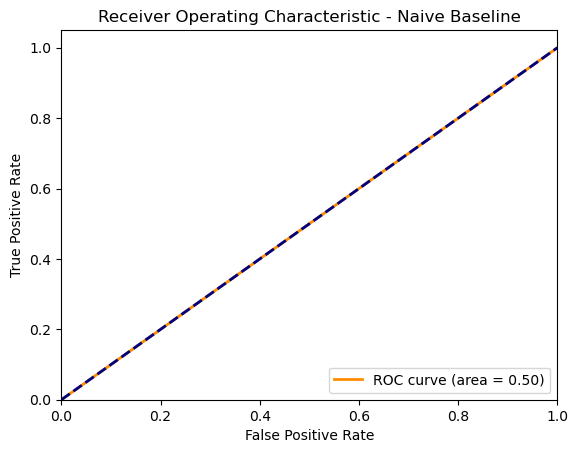

(1.211828993715628, 0.797, 0.01932367149758454, 0.5)

In [28]:
# Naive Baseline
naive_baseline = NaiveBaseline()
naive_baseline.fit(X_train_selected, y_train_selected, X_val_selected, y_val_selected)
y_pred = naive_baseline.predict(X_val_selected)
y_pred_proba = naive_baseline.predict_proba(X_val_selected)
evaluate("Naive Baseline", y_val_selected, y_pred, y_pred_proba, plot=True)

The results here match expectations: The Naive Model has an Area Under the Curve (AUC) of 0.5, which means it is as good as random: The probability that a randomly positive instance gets higher output score than a randomly drawn negative instance is 50%.

Recall and precision are low, which is expected given the random nature of the model. The accucary is relatively high, which is due to the imbalance of the data, but it is not a good metric to evaluate the model's performance in this case.

Next, I will train the Logistic Regression model on the selected features.


### Logistic Regression


#### Nested Cross-Validation


In [29]:
param_grid_lr = {
    "n_features": [X_selected.shape[1]],
    "epochs": [10, 20, 30],
    "learning_rate": [0.1, 0.05, 0.01],
    "lambda_reg": [0.1, 0.01, 0.001],
}

Performing nested cross-validation for model Binary Logistic Regression with 5000 samples
Risk estimate for argmin(R_ests_params): 0.431203867143375447: 0.44956165679782895
Selected best parameters: {'n_features': 3, 'epochs': 20, 'learning_rate': 0.1, 'lambda_reg': 0.001}
Binary Logistic Regression – Empirical Risk Estimate: 0.4326625244737709, Accuracy: 0.7598, F1 score: 0.4106326848282034, Precision: 0.27178922773035485, Recall: 0.8410820460604125, AUC: 0.8783259164403588
            Pred Neg  Pred Pos
Actual Neg       678       219
Actual Pos        17        86


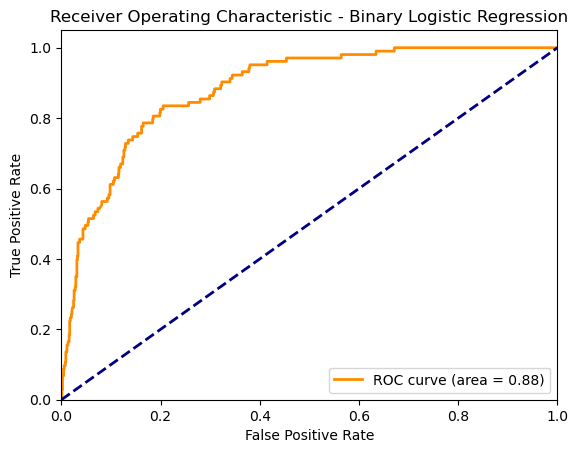

In [49]:
k = 5

lr_final, lr_params, lr_R_est, lr_acc, lr_f1, lr_auc = nested_cross_validation(
    X_selected,
    y_selected,
    BinaryLogisticRegression,
    param_grid_lr,
    k=k,
)

The nested cross-validation scheme has found the best hyperparameters for the Logistic Regression model: {'epochs': 20, 'learning_rate': 0.1, 'lambda_reg': 0.001}

The model seems to converge. It does not seem to be overfitting. The AUC is around 0.88 on the validation set (1000 samples), indicating the model's ability to separate classes. The precision is relatively low, while the recall is relatively high. The penalty weights that were used to counteract the imbalanced dataset made the model more liberal, and it may have some difficulty to separate classes. The model's tendency to lean towards positive predictions is further reflected by the confusion matrix.


### Neural Network


#### Nested Cross-Validation


In [31]:
param_grid_nn = {
    "n_features": [X_original.shape[1]],
    "epochs": [10, 20, 30],
    "learning_rate": [0.1, 0.05, 0.01],
    "lambda_reg": [0.1, 0.01, 0.001],
    "n_hidden_units": [16, 32, 64],
    "n_hidden_layers": [1, 2],
}

Performing nested cross-validation for model Binary Neural Network with 5000 samples
Risk estimate for argmin(R_ests_params): 0.43757705619196885162: 0.45009287877300624
Selected best parameters: {'n_features': 16, 'epochs': 30, 'learning_rate': 0.05, 'lambda_reg': 0.01, 'n_hidden_units': 32, 'n_hidden_layers': 1}
Binary Neural Network – Empirical Risk Estimate: 0.43897262965985584, Accuracy: 0.7506, F1 score: 0.4066613515367429, Precision: 0.2672795367251504, Recall: 0.85771651065744, AUC: 0.8732469714613273
            Pred Neg  Pred Pos
Actual Neg       655       255
Actual Pos        13        77


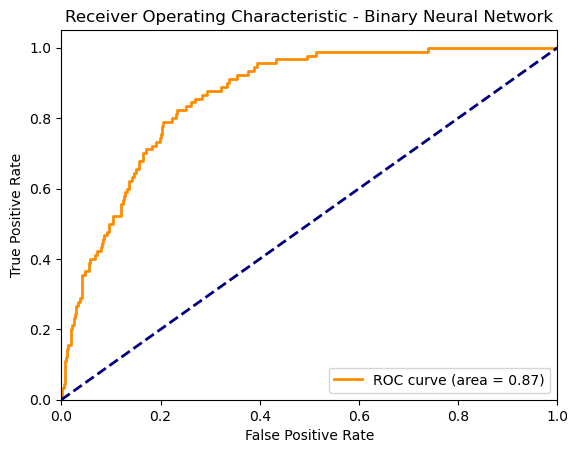

In [50]:
k = 5

nn_final, nn_params, nn_R_est, nn_acc, nn_f1, nn_auc = nested_cross_validation(
    X_original,
    y_original,
    BinaryNeuralNetwork,
    param_grid_nn,
    k=k,
)

The Neural Network model has found the best hyperparameters: {'epochs': 30, 'learning_rate': 0.05, 'lambda_reg': 0.01, 'n_hidden_units': 32, 'n_hidden_layers': 1}

The model converges, and it does not seem to be overfitting. Similar to the Logistic Regression Model, the Neural Network tends to be liberal in its predictions, yet slightly more so than the Logistic Regression model: Both precision and recall are slightly lower compared to the Logistic Regression model. The AUC is around 0.87 on the validation set (1000 samples), cutting slightly behind the Logistic Regression Model, meaning that considering varying decision thresholds, the Logistic Regression model is better at distinguishing between classes.


Given the better AUC score of the Logistic Regression model, I will use latter to make predictions on the test data and store them as a CSV file to submit.


In [227]:
y_pred_final = lr_final.predict_proba(X_test_selected)

# save predictions as csv in the format id,stroke
path_predictions = "data/predictions.csv"
predictions = pd.DataFrame({"id": test_ids, "stroke": y_pred_final})
predictions.to_csv(base_path / path_predictions, index=False)

## Conclusion <a id="7"></a>


In this notebook, I engaged in a binary classification problem to predict stroke occurences in subjects, using both a Logistic Regression model and a Neural Network model. Despite the ability of the Neural Network to handle non-linear relationships in the data, it did not outperform the Logistic Regression model that was trained on selected mappings of non-linear to linear features, which achieved an AUC score of 0.88 on the validation set, slightly higher than the Neural Network. This suggests that the feature mappings that were created during the feature engineering step capture necessary complexity as good as or slightly better as the Neural Network's internal architecture. Given the results, Logistic Regression is the better choice for this data set and context regarding the AUC metric, which is important in critical medical health applications, in which decision thresholds may be adapted to minimize false negatives. Future work may experiment with bigger data sets, higher-order polynomial features, more complex neural network architectures as well as adaptive learning rates, to further improve the models' performances.
